### This Notebook aims to run experiments to see the focus of the baseline seq2seq models for DA classification.

It was hypothesised that all the encoder has all utterance seperation information, it's hard for the decoder to know what the current utterance has to be (due to complex information overload) and this notebook looks at how much focus the decoder has for each decision.

In [1]:
import sys

sys.path.append('/home/alta/Conversational/OET/al826/2022/seq_cls')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from types import SimpleNamespace
import scipy

from src.eval_handler import EvalHandler
from src.config import config

In [3]:
from src.eval_handler import EvalHandler

#E = EvalHandler('seq2seq/led_rand')
E = EvalHandler('seq2seq/led_base')
#E = EvalHandler('seq2seq/post_encoder')

eval_path = f"{config.base_dir}/data/swda/standard/dev.json"
l_path = f"{config.base_dir}/data/swda/standard/labels.json"

args = {'test_path':eval_path,
        'bsz':1, 
        'override':False,
        'label_path':l_path, 
        'system_args':None}

args = SimpleNamespace(**args)

cross_attentions = E.attention(args, conv_num=0, free=False)

using baseline seq2seq set up


100%|██████████| 21/21 [00:00<00:00, 89.83it/s]


In [4]:
#print(E.model.config)

getting average attentions over all conversations

In [5]:
sh_1, sh_2 = 300, 300

free_output = np.zeros((72, sh_1, sh_2))
forced_output = np.zeros((72, sh_1, sh_2))

free_cache = []
forced_cache = []

for i in range(21):
    attentions = E.attention(args, conv_num=i, free=False)[:,:sh_1,:sh_2]
    d1, d2, d3 = attentions.shape
    forced_output[:,:d2, :d3] = forced_output[:,:d2, :d3] + attentions
    forced_cache.append(attentions)
    
    attentions = E.attention(args, conv_num=i, free=True)[:,:sh_1,:sh_2]
    d1, d2, d3 = attentions.shape
    free_output[:,:d2, :d3] = free_output[:,:d2, :d3] + attentions
    free_cache.append(attentions)
      
row_sums = forced_output.sum(axis=-1)
forced_attn = forced_output/row_sums[:,:,np.newaxis]

row_sums = free_output.sum(axis=-1)
free_attn = free_output/row_sums[:,:,np.newaxis]


100%|██████████| 21/21 [00:00<00:00, 89.75it/s]


(140, 140)


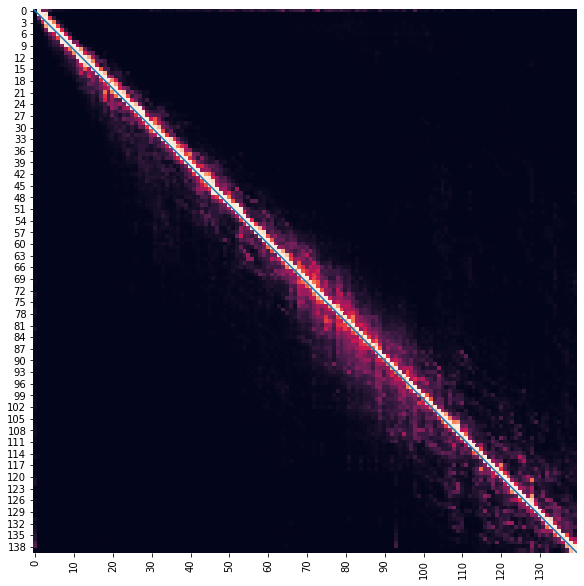

(140, 140)


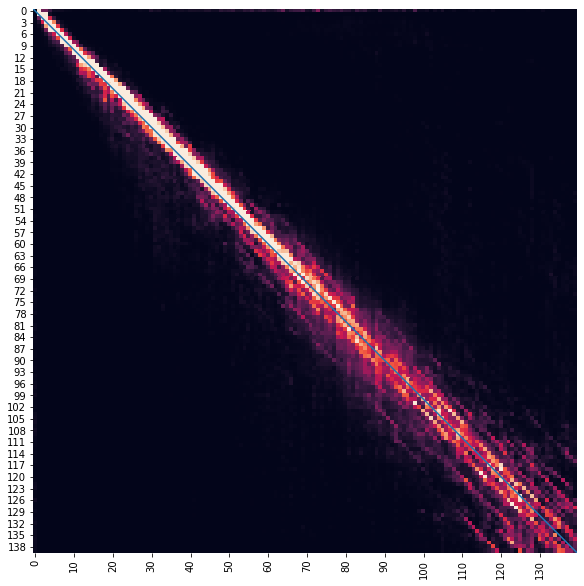

In [6]:
for attn in [forced_attn, free_attn]:
    fig, ax = plt.subplots(figsize=(20,10))         # Sample figsize in inches
    avg_attn = np.mean(attn[-12:], axis=0)
    #avg_attn = np.mean(attn[-16:], axis=0)

    avg_attn = avg_attn[:140,:140]
    ax = sns.heatmap(avg_attn, cbar=False, square=True, vmin=0, vmax=0.1)

    xticks=ax.xaxis.get_major_ticks()
    for i in range(len(xticks)):
        if i%5!=0:
            xticks[i].set_visible(False)

    print(avg_attn.shape)
    ax.axline((0, 0), slope=1)
    plt.show()

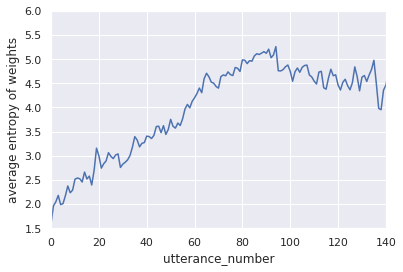

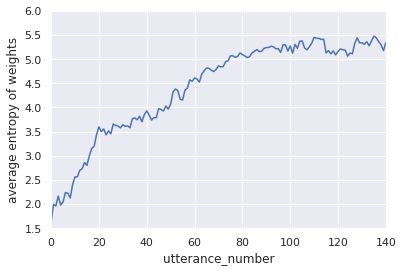

In [7]:
sns.set_theme()

for attn, cache in [(forced_attn, forced_cache), (free_attn, free_cache)]:
    avg_attn = np.mean(attn[-12:], axis=0)
    log_attn = np.log2(avg_attn)
    entropy = -1*np.sum(avg_attn*log_attn, axis=1)
    plt.plot(entropy[2:])
    
    if False:
        for attn in cache[:3]:
            avg_attn = np.mean(attn[-12:], axis=0)
            log_attn = np.log2(avg_attn)
            entropy = -1*np.sum(avg_attn*log_attn, axis=1)
            plt.plot(entropy[2:], '')    
        
    plt.xlabel('utterance_number')
    plt.ylabel('average entropy of weights')
    plt.xlim(0, 140)
    plt.ylim(1.5,6.0)
    plt.show()

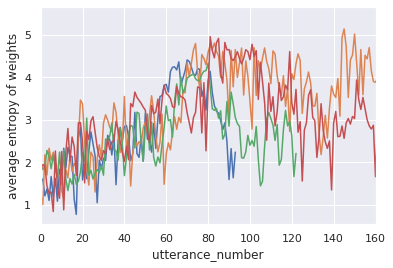

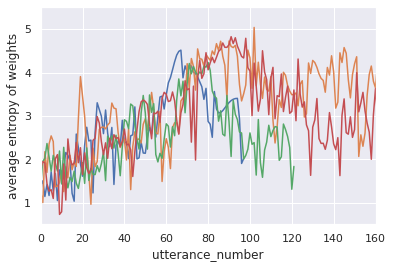

In [11]:
sns.set_theme()

for attn, cache in [(forced_attn, forced_cache), (free_attn, free_cache)]:
    avg_attn = np.mean(attn[-12:], axis=0)
    log_attn = np.log2(avg_attn)
    entropy = -1*np.sum(avg_attn*log_attn, axis=1)
    #plt.plot(entropy[2:], '--')
    
    if True:
        for attn in cache[:4]:
            avg_attn = np.mean(attn[-12:], axis=0)
            log_attn = np.log2(avg_attn)
            entropy = -1*np.sum(avg_attn*log_attn, axis=1)
            plt.plot(entropy[2:])    
        
    plt.xlabel('utterance_number')
    plt.ylabel('average entropy of weights')
    plt.xlim(0, 160)
    plt.show()

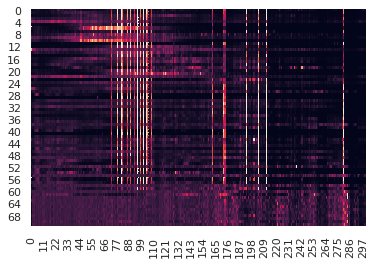

In [31]:
x = np.sum(free_attn, axis=1)/300
ax = sns.heatmap(x, cbar=False, square=False, vmin=0, vmax=0.02)
